# Homework 9 - Text Simplification as Machine Translation


## Total Points: 104 points
- **Overview**: In this homework assignment, you will learn about text simplification and will fine-tune GPT to translate complex English sentences into simple ones. We'll cover:

  - Exploring text completexity and how to measure it
  - Write simpler versions of sentences manually
  - Use prompting to simplify text with GPT
  - Fine-tune GPT to translate between complex and simple English

- **Grading**: We will use the auto-grading system called `PennGrader`. To complete the homework assignment, you should implement anything marked with `#TODO` and run the cell with `#PennGrader` note.


## Related Readings (Optional)

- [Simple-qe: Better automatic quality estimation for text simplification](https://arxiv.org/abs/2012.12382) Reno Kriz, Marianna Apidianaki, and Chris Callison-Burch, arXiv preprint arXiv:2012.12382, 2020.

- [Complexity-weighted loss and diverse reranking for sentence simplification](https://arxiv.org/abs/1904.02767) Reno Kriz, João Sedoc, Marianna Apidianaki, Carolina Zheng, Gaurav Kumar, Eleni Miltsakaki, and Chris Callison-Burch, arXiv preprint arXiv:1904.02767, 2019.

- [Simplification using paraphrases and context-based lexical substitution](https://aclanthology.org/N18-1019) Reno Kriz, Eleni Miltsakaki, Marianna Apidianaki, and Chris Callison-Burch, Proceedings of the 2018 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long Papers), pp. 207-217, 2018.

- [Optimizing statistical machine translation for text simplification](https://www.aclweb.org/anthology/Q16-1029) Wei Xu, Courtney Napoles, Ellie Pavlick, Quanze Chen, and Chris Callison-Burch, Transactions of the Association for Computational Linguistics 4, pp. 401-415, 2016.

- [Simple PPDB: A paraphrase database for simplification](https://aclanthology.org/P16-2024/) Ellie Pavlick, and Chris Callison-Burch, Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 2: Short Papers), pp. 143-148, 2016.

- [Problems in current text simplification research: New data can help](https://aclanthology.org/Q15-1021/) Wei Xu, Chris Callison-Burch, and Courtney Napoles, Transactions of the Association for Computational Linguistics 3, pp. 283-297, 2015.

## To get started, **make a copy** of this colab notebook into your google drive!

## PennGrader setup

In [1]:
## DO NOT CHANGE ANYTHING, JUST RUN
%%capture
!pip install penngrader-client

In [2]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing notebook-config.yaml


In [3]:
!cat notebook-config.yaml


grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'


In [4]:
from penngrader.grader import *

## TODO - Start
STUDENT_ID = 62502470 # YOUR PENN-ID GOES HERE AS AN INTEGER#
## TODO - End

SECRET = STUDENT_ID
grader = PennGrader('notebook-config.yaml', 'CIS5300_OL_23Su_HW9', STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 62502470

Make sure this correct or we will not be able to store your grade


In [5]:
# check if the PennGrader is set up correctly
# do not change this cell, see if you get 4/4!
name_str = 'Rui Jiang'
grader.grade(test_case_id = 'name_test', answer = name_str)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Section 1: Exploring Text Complexity
**Background:** Text simplification is the process of converting complex sentences into simple ones that are still faithful to the originl meaning. It can be used in cases where a complex document needs to be translated into a simpler form for a particular audience, like children, non-native speakers, and people who face reading difficulties. Even computational tasks like machine translation and text summarization can benefit from simplifying text first.

Over the years, research on text simplification has evolved from simple, rule-based approaches like substituting complex words with simpler ones, or splitting long sentences into more easily understandable shorter ones, to more complex methods that leverage large language models to understand complex pieces of information and generate simpler versions.

Here, we will attempt and evaluate different methods and finally use modern techniques like fine-tuning GPT to "translate" complex text into simple text.

First, let's install and import the required libraries.

In [8]:
%%capture
!pip install openai textstat nltk pandas jsonlines wandb scikit-learn

import os
from openai import OpenAI
import textstat
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import pandas as pd
from random import sample
import numpy as np
import json
import time
import seaborn as sns
import string
import glob
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

In [9]:
%%capture
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

In [10]:
from getpass import getpass
import os

print('Enter OpenAI API key:')
openai_api_key = getpass()

os.environ['OPENAI_API_KEY']=openai_api_key
client = OpenAI()

Enter OpenAI API key:
··········


### What makes a sentence simple?

**Problem 1.1**

Before we use computers to perform this task, let's first try to do it ourselves to understand it better. Pick five complex sentences you may have recently read (or find some on the Internet), and write your own simplified versions of them.

Example:

In [11]:
original_sentence = "The diversification in occupational roles has become a crucial attribute in today's rapidly evolving job market."

simplified_sentence = "Having a variety of job roles is important for today's fast-changing job market."

example_sentence_pair = (original_sentence, simplified_sentence)

In [14]:
  # TODO


##################################################
# original_sentence_1 = "The dramatic research and funding cuts and changes to skilled worker immigration policies threaten one of its greatest economic advantages: people powered innovation."
original_sentence_1 = "The dramatic research and funding cuts and changes to skilled worker immigration policies threaten the greatest economic advantages as people powered innovation."
original_sentence_2 = "One recent analysis from economists at University found that current and proposed cuts to federal research spending could whack the economy"
original_sentence_3 = "There is little question that Alphabet has found itself in some trouble, largely because of antitrust scrutiny in the America and Europe."
original_sentence_4 = "Consumers and companies are relying increasingly on artificial intelligence as a source of information and as an internet entry point, challenging a search business that accounted for nearly half of its revenue in its latest quarter."
original_sentence_5 = "The artificial intelligence company CoreWeave, which went public earlier this year, said the acquisition will help it verticalize its data center footprint, resulting in revenue growth and enhanced profitability."

simplified_sentence_1 = "The research funding cut and change in immigration policies threaten the people powered innovation."
simplified_sentence_2 = "One analysis found that the coming research funding cuts could hurt the economy."
simplified_sentence_3 = "The antitrust in the America and Europe has caused the trouble for the Alphabet"
simplified_sentence_4 = "Artificial intelligence is increasingly becoming an internet entry point that can impact nearly half of its revenue."
simplified_sentence_5 = "CoreWeave said the acquisition will help to grow the revenue."

pair_1 = (original_sentence_1, simplified_sentence_1)
pair_2 = (original_sentence_2, simplified_sentence_2)
pair_3 = (original_sentence_3, simplified_sentence_3)
pair_4 = (original_sentence_4, simplified_sentence_4)
pair_5 = (original_sentence_5, simplified_sentence_5)

##################################################

pairs = [pair_1, pair_2, pair_3, pair_4, pair_5]

In [13]:
grader.grade(test_case_id = 'test_five_sentences', answer = pairs)

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**Problem 1.2**

After completing the above task, list five general changes (not specifically to the pairs above) that you might make to a complex sentence to transform it into a simpler one. Your answers should be included in your separate "***writeup.pdf***" file and will be manually graded (5 points).

In [ ]:
# TODO in writeup.pdf file


### Measuring complexity

While it may be clear to you that the transformed sentences are simpler than the original ones, we need a way to quanitify this so that we can automate the process.

One way to think about this is to measure the 'readability' of a text. The most well-known readability metric are the Flesch–Kincaid tests. The test have two types: Flesch Reading-Ease and Flesch–Kincaid Grade Level.

The Flesch Reading-Ease test is scored on a scale of 1-100, with higher scores indicating that the text is easier to read. The score is calculated by the following formula:

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/bd4916e193d2f96fa3b74ee258aaa6fe242e110e)


The table below shows a breakdown of the different levels and how they translate to school levels.


| Score | School level (US) | Notes                                                           |
|-------|------------------|-----------------------------------------------------------------|
| 100.00–90.00 | 5th grade  | Very easy to read. Easily understood by an average 11-year-old student. |
| 90.0–80.0 | 6th grade | Easy to read. Conversational English for consumers.                   |
| 80.0–70.0 | 7th grade | Fairly easy to read.                                                |
| 70.0–60.0 | 8th & 9th grade | Plain English. Easily understood by 13- to 15-year-old students.  |
| 60.0–50.0 | 10th to 12th grade | Fairly difficult to read.                                      |
| 50.0–30.0 | College | Difficult to read.                                                 |
| 30.0–10.0 | College graduate | Very difficult to read. Best understood by university graduates. |
| 10.0–0.0 | Professional | Extremely difficult to read. Best understood by university graduates. |

\
The Flesch–Kincaid Grade Level, on the other hand, calculates the approximate U.S. grade level that corresponds to the complexity of the given text. It is therefore inversely related to the Flesch Reading-Ease, since lower school grade levels correspond to text that is easier to read, and provides a more interpretable understanding of the complexity of a text. It is calculated by the following formula:

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/8e68f5fc959d052d1123b85758065afecc4150c3)

Notice how, in both tests, having more words per sentence, and having more syllables per word, both increase the complexity of text.

**Problem 1.3**

Using the appropriate functions in the `textstat` module, evaluate the complexity of your sentences and confirm that the simplified ones score accordingly on both metrics. You can find the documentation for it [here](https://github.com/textstat/textstat). Look for functions that measure the **Flesch Reading-Ease** and **Flesch–Kincaid Grade Level**.

Your solution should be formatted as follows:

```
reading_ease = [(pair1_complex_sentence_score, pair1_simple_sentence_score), ...]
grade_level = [(pair1_complex_sentence_score, pair1_simple_sentence_score), ...]
```


In [ ]:
# TODO
import textstat

reading_ease = []
grade_level = []

# pairs = [pair_1, pair_2, pair_3, pair_4, pair_5]
for pair in pairs:
  reading_ease.append((textstat.flesch_reading_ease(pair[0]), textstat.flesch_reading_ease(pair[1])))
  grade_level.append((textstat.flesch_kincaid_grade(pair[0]), textstat.flesch_kincaid_grade(pair[1])))

##################################################
print(reading_ease)
print(grade_level)

##################################################

[(7.614090909090919, 29.467857142857156), (20.34857142857146, 50.470769230769264), (38.37772727272727, 53.639285714285734), (12.845000000000027, 15.403529411764737), (5.282758620689691, 69.78500000000001)]
[(17.66272727272727, 12.62714285714286), (15.638095238095236, 9.44923076923077), (13.371818181818181, 9.255714285714287), (20.411111111111115, 15.334117647058822), (19.726896551724135, 6.010000000000002)]


In [ ]:
grader.grade(test_case_id = 'test_compare_complexity', answer = (reading_ease, grade_level, pairs))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Evaluating simplification quality

While measuring the change in Flesch-Kincaid Grade Level is one measure of how good a simplification is, another way to measure its quality is to see how faithful it is to the original sentence. While we want the simplification to be concise, we also want it to retain the meaning of the original.

### Measuring semantic similarity

In order to measure the similarity of two sentences, we can compute the difference between their vector embeddings. We studied word embeddings earlier in the class, which let us represent words as vectors we can use to compute how similar two words are to each other. The same can be done for sentences, and even documents, using large language models (LLMs). Let's see how this works.

**Problem 1.4**

Define a function that gets the embeddings for a given piece of text from the OpenAI API. Use the `text-embedding-ada-002` model, which accepts a list of strings as input and returns a list embeddings in response. You can look at the API documentation [here](https://platform.openai.com/docs/guides/embeddings/use-cases).

In [ ]:
# TODO

def get_embedding(text, model="text-embedding-ada-002"):

  response = client.embeddings.create(
    input=text,
    model=model
  )

  embeddings = response.data[0].embedding


  ##################################################

  ##################################################

  return embeddings

embeddings = [(get_embedding(i), get_embedding(j)) for (i, j) in pairs]

In [ ]:
embeddings[0][0]

[-0.01226769294589758,
 -0.02714553475379944,
 0.02089456468820572,
 -0.032312288880348206,
 -0.013659771531820297,
 0.004939202219247818,
 -0.022407112643122673,
 0.015098699368536472,
 -0.007763515692204237,
 -0.028537612408399582,
 0.011163400486111641,
 0.014884533360600471,
 0.028698237612843513,
 0.007576120551675558,
 -0.02714553475379944,
 0.0013929152628406882,
 0.028939174488186836,
 -0.021965395659208298,
 -0.006408246699720621,
 -0.012796415016055107,
 -0.023651951923966408,
 0.023759035393595695,
 0.014308962039649487,
 -0.0029280500020831823,
 -0.0027423279825598,
 0.010433897376060486,
 0.0159553624689579,
 -0.03201780840754509,
 0.005678744055330753,
 -0.01073506847023964,
 0.0020312301348894835,
 0.0019776886329054832,
 -0.006471827160567045,
 -1.6797073840280063e-05,
 -0.03592633828520775,
 -0.02438814751803875,
 0.002302283886820078,
 -0.00572224659845233,
 0.010099262930452824,
 -0.011585039086639881,
 0.016008904203772545,
 -0.0027055181562900543,
 -0.0056352415122

In [ ]:
grader.grade(test_case_id = 'test_embeddings', answer = (embeddings, pairs, openai_api_key))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**Problem 1.5**

Now use the cosine similarity function we imported from `scikit-learn` to compare the embeddings of all pairs of sentences. You can read its documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html).

Completely identical sentences should have a similarity of 1.0, while sentences roughly on the same topic might have a cosine similarity of 0.9. Ideally, we want our simplified sentences to be as close to their original, complex versions as possible.

In [ ]:
# TODO
import sklearn.metrics.pairwise
sim = []

X = []
Y = []
for i, j in embeddings:
  X.append(i)
  Y.append(j)


for i in range(5):
  sim.append(sklearn.metrics.pairwise.cosine_similarity([X[i]], [Y[i]]))

##################################################
sim

##################################################


##################################################

[array([[0.95710044]]),
 array([[0.94249043]]),
 array([[0.94579546]]),
 array([[0.94189123]]),
 array([[0.90776637]])]

In [ ]:
grader.grade(test_case_id = 'test_compute_sim', answer = (sim, embeddings, openai_api_key))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Section 2: Rule-based Simplification

Given what we have learned from the above exercise, let's now try to write a simple rule-based system for simplifying sentences.

One of the ways to simplify a sentence is to use simpler words in the place of complex ones. Use the wordnet lexical database to replace complex words in a sentence with their synonyms that are simpler. Some heuristics you might want to consider are the word length, number of syllables, and frequency in the English corpus.

**Problem 2.1**

Using WordNet, list all the synonyms of the following words:
language, research, complex, simple, model. Your answer should be a list of length five, where each element is an alphabetically sorted list containing all the synonyms of the respective word.


```
[
  ['word1_synonym1', 'word1_synonym2', ... ],
  ['word2_synonym1', 'word2_synonym2', ... ],
  ...
]
```


You can see the NLTK WordNet documentation [here](https://www.nltk.org/howto/wordnet.html).


In [ ]:
help(wordnet.synsets)

Help on method synsets in module nltk.corpus.reader.wordnet:

synsets(lemma, pos=None, lang='eng', check_exceptions=True) method of nltk.corpus.reader.wordnet.WordNetCorpusReader instance
    Load all synsets with a given lemma and part of speech tag.
    If no pos is specified, all synsets for all parts of speech
    will be loaded.
    If lang is specified, all the synsets associated with the lemma name
    of that language will be returned.



In [ ]:
syns = wordnet.synsets("language")

In [ ]:
help(syns[0])

Help on Synset in module nltk.corpus.reader.wordnet object:

class Synset(_WordNetObject)
 |  Synset(wordnet_corpus_reader)
 |  
 |  Create a Synset from a "<lemma>.<pos>.<number>" string where:
 |  <lemma> is the word's morphological stem
 |  <pos> is one of the module attributes ADJ, ADJ_SAT, ADV, NOUN or VERB
 |  <number> is the sense number, counting from 0.
 |  
 |  Synset attributes, accessible via methods with the same name:
 |  
 |  - name: The canonical name of this synset, formed using the first lemma
 |    of this synset. Note that this may be different from the name
 |    passed to the constructor if that string used a different lemma to
 |    identify the synset.
 |  - pos: The synset's part of speech, matching one of the module level
 |    attributes ADJ, ADJ_SAT, ADV, NOUN or VERB.
 |  - lemmas: A list of the Lemma objects for this synset.
 |  - definition: The definition for this synset.
 |  - examples: A list of example strings for this synset.
 |  - offset: The offset

In [ ]:
print(syns[0].name())
print(syns[0].definition())
print(syns[0].examples())
print(syns[0].lemmas())

language.n.01
a systematic means of communicating by the use of sounds or conventional symbols
['he taught foreign languages', 'the language introduced is standard throughout the text', 'the speed with which a program can be executed depends on the language in which it is written']
[Lemma('language.n.01.language'), Lemma('language.n.01.linguistic_communication')]


In [ ]:
help(syns[0].lemmas()[0])

Help on Lemma in module nltk.corpus.reader.wordnet object:

class Lemma(_WordNetObject)
 |  Lemma(wordnet_corpus_reader, synset, name, lexname_index, lex_id, syntactic_marker)
 |  
 |  The lexical entry for a single morphological form of a
 |  sense-disambiguated word.
 |  
 |  Create a Lemma from a "<word>.<pos>.<number>.<lemma>" string where:
 |  <word> is the morphological stem identifying the synset
 |  <pos> is one of the module attributes ADJ, ADJ_SAT, ADV, NOUN or VERB
 |  <number> is the sense number, counting from 0.
 |  <lemma> is the morphological form of interest
 |  
 |  Note that <word> and <lemma> can be different, e.g. the Synset
 |  'salt.n.03' has the Lemmas 'salt.n.03.salt', 'salt.n.03.saltiness' and
 |  'salt.n.03.salinity'.
 |  
 |  Lemma attributes, accessible via methods with the same name:
 |  
 |  - name: The canonical name of this lemma.
 |  - synset: The synset that this lemma belongs to.
 |  - syntactic_marker: For adjectives, the WordNet string identifying 

In [ ]:
# TODO
words = ['language', 'research', 'complex', 'simple', 'model']

from nltk.corpus import wordnet

"""
wn.synsets() --> lemmas() --> lemma.name()
"""
def get_synonyms(word):

  synonyms = set()
  for syn in wordnet.synsets(word):
    for lemma in syn.lemmas():
      synonyms.add(str(lemma.name()))  # Get the name of the synonym
  synonyms = sorted(list(synonyms))
  return synonyms

  ##################################################

  ##################################################

  return synonyms

synonyms = [get_synonyms(word) for word in words]

In [ ]:
grader.grade(test_case_id = 'test_synonyms', answer = (synonyms))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Once we have a list of possible replacements for a word, we need a way to pick the simplest one. One heuristic for this is how common a word is in the English language -- common words tend to be simpler than rare ones. To get the frequency of a word, you can use the Google n-grams corpus from your text classification homework.

Let's download and unzip the Google n-gram dataset first.

In [ ]:
!curl -L -o ngram_counts.txt.gz http://www.cis.upenn.edu/~cis5300/18sp/data/ngram_counts.txt.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   272  100   272    0     0   1710      0 --:--:-- --:--:-- --:--:--  1721
100 42.4M  100 42.4M    0     0  23.3M      0  0:00:01  0:00:01 --:--:-- 35.8M


In [ ]:
!gzip -d ngram_counts.txt.gz

gzip: ngram_counts.txt already exists; do you wish to overwrite (y or n)? y


In [ ]:
!cat ./ngram_counts.txt | wc -l

8749928


**Problem 2.2**

Write a function to extract the frequency of a given word from the n-gram dataset. It might help to store the n-grams in a data structure that allows efficient retrieval. You should return the frequency as an integer. If a word does not appear in the n-gram dataset, its frequency should be 0.

In [ ]:
# TODO

##################################################
dictionary = {}
with open("./ngram_counts.txt", "r", encoding="utf-8") as file:
  for line in file:
    segments = line.split('\t')
    word = segments[0]
    frequency = int(segments[1])
    dictionary[word] = frequency

def get_freq(word):
  if word not in dictionary:
    return 0
  return dictionary[word]

##################################################


In [ ]:
freqs = [get_freq(word) for word in words]
freqs

[158634832, 141020788, 81674722, 115821272, 135750514]

In [ ]:
grader.grade(test_case_id = 'test_word_freq', answer = freqs)

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**Problem 2.3**

Now put both of these pieces together to write a function that, given a sentence, replaces each word with its simplest i.e. most common synonym. You will find all possible synonyms for each word in the sentence and replace them with the most frequently occuring one.

Example input: Science is a subject that requires meticulous attention to detail and rigorous experimentation

Example output: Science be a case that take meticulous care to point and strict experiment

In [ ]:
text = "The diversification in occupational roles has become a crucial attribute in today's rapidly evolving job market"
text.split(" ")
get_synonyms("The")

[]

In [ ]:
# TODO
import numpy as np

def synonym_simplify(text):
  new_segments = []
  segments = text.split(" ")
  for segment in segments:
    synonyms_frequency = []
    synonyms = get_synonyms(segment)
    if len(synonyms) == 0:
      new_segments.append(segment)
      continue
    for synonym in synonyms:
      synonyms_frequency.append((synonym, get_freq(synonym)))
    max_freq = np.argmax([t[1] for t in synonyms_frequency])
    segment = synonyms[max_freq]
    new_segments.append(segment)
  output = " ".join(new_segments)

  ##################################################
  ##################################################

  return output

simplified = synonym_simplify("The diversification in occupational roles has become a crucial attribute in today's rapidly evolving job market")
simplified


"The diversification in occupational use have get a important property in today's quickly develop line market"

In [ ]:
grader.grade(test_case_id = 'test_synonym_simplify', answer = simplified)

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Section 3: Simplification via Prompting

Since you have seen that simplification is a hard task to do using hard-coded rules, let's try using large language models to simplify text for us. We will use GPT-4o-mini for this task.

## Zero-shot

In zero-shot prompting, we simply give the model a piece of input, called a prompt, which may contain a question or instruction, and ask the model to process it and return an output.


**Problem 3.1**

Write a prompt that asks GPT to simplify a given sentence. The input (complex) sentence will be appended to the end of the prompt. In response, GPT should return the resulting (simple) sentence.

In [15]:
# TODO

def simplify_zeroshot(prompt, sentence):

  messages = [
        {"role": "user", "content": prompt + sentence},  # appending the sentence to the prompt
  ]

  response = client.chat.completions.create(
      model="gpt-4o-mini",
      messages=messages,
      temperature=0.7,
      max_tokens=256,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0,
      # stop=["\n"]
  )

  # We recommend putting a short wait after each call,
  # since the rate limit for the platform is 60 requests/min.
  # (This increases to 3000 requests/min after you've been using the platform for 2 days).
  time.sleep(1)

  # the response from OpenAI's API is a JSON object that contains
  # the completion to your prompt plus some other information. Here's how to access
  # just the text of the completion.
  return response.choices[0].message.content.strip()

##################################################
prompt = "Please simplify a sentence by using a simpler word in the sentence. The sentence need to be simplified is: "
##################################################

simplify_zeroshot(prompt, original_sentence)

"The variety in job roles has become an important feature in today's fast-changing job market."

Here is some information about the different arguments that we gave to the `client.completions.create` call:
 * `model` – Model ID used to generate the response, like gpt-4o or gpt-4o-mini, which we use here.
 * `messages` - A list of messages comprising the conversation so far.
 * `temperature` - controls how much of the probability distribution the model will use when it is generating each token. 1.0 means that it samples from the complete probability distrubiton, 0.7 means that it drops the bottom 30% of the least likely tokens when it is sampling. 0.0 means that it will perform deterministically and always output the single most probable token for each context.
 * `top_p` - is an alternative way of controling the sampling.
 * `frequency_penalty` and `presence_penalty` are two ways of reduing the model from repeating the same words in one output.  You can set these to be >0 if you're seeing a lot of repetition in your output.
 * `max_tokens` is the maximum length in tokens that will be output by calling the function.  A token is a subword unit.  There are roughly 2 or 3 tokens per word on average.
 * `stop` is a list of stop sequences.  The model will stop generating output once it generates one of these strings, even if it hasn't reached the max token length. By default this is set to a special token `<|endoftext|>`.

You can read more about [the Chat Completions API call in the documentation](https://platform.openai.com/docs/api-reference/chat).

In [ ]:
grader.grade(test_case_id = 'test_zeroshot', answer = (openai_api_key, prompt))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Try this prompt on all five of your complex sentences and calculate the readibility metrics on both the simplified forms. Confirm that the simplified sentences are more readable than the originals, and compare the level of simplification performed by GPT against your manual attempt.

In [ ]:
simple_sentences_gpt = [simplify_zeroshot(prompt, i) for i, j in pairs]
simple_sentences_gpt

['The major research and funding cuts and changes to skilled worker immigration policies threaten the biggest benefits of people-driven innovation.',
 'A recent study from economists at the university found that current and proposed cuts to federal research spending could hurt the economy.',
 'There is little doubt that Alphabet is in some trouble, mainly because of antitrust reviews in America and Europe.',
 'Consumers and companies are increasingly using artificial intelligence for information and as a way to access the internet, challenging a search business that made nearly half of its revenue last quarter.',
 'The artificial intelligence company CoreWeave, which went public earlier this year, said the purchase will help it focus its data center operations, leading to revenue growth and increased profits.']

**Problem 3.2**

You can also vary how much you want GPT to simplify a sentence. Write two prompts, one which simplifies the input sentence a little, and another which simplifies the input sentence comparatively more.

You can try doing this at different levels and check whether the Flesch-Kincaid scores change accordingly.


In [ ]:
# TODO

##################################################
prompt_less_simple =  "Simplify the following sentence "
prompt_more_simple =  "Rewrite this sentence in mush simpler English for elementary school student:"
##################################################

print(simplify_zeroshot(prompt_less_simple, original_sentence))
print(simplify_zeroshot(prompt_more_simple, original_sentence))

The variety of job roles is essential in today's fast-changing job market.
Having different types of jobs is very important in today’s fast-changing job market.


In [ ]:
original_sentence

"The diversification in occupational roles has become a crucial attribute in today's rapidly evolving job market."

In [ ]:
grader.grade(test_case_id = 'test_zeroshot_levels', answer = (openai_api_key, prompt_less_simple, prompt_more_simple))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


You can also give GPT specific instructions on how it should simplify a sentence. Try writing prompts explicitly instructing GPT to make the specific changes you listed above in Problem 1.2 and see whether that works.

In [ ]:
##################################################
prompt_change_1 = "Please simply the given sentence with mushc simple English word: "
##################################################

print(simplify_zeroshot(prompt_change_1, original_sentence))

Having different types of jobs is very important in today’s fast-changing job market.


## Few-shot

One way to make GPT do a better job at a task is to give it a few examples describing what we want instead of just giving it an instruction. We can do this by providing a few pairs of complex and simple sentences (in that order, and separated by a hypen) in the prompt, and GPT will learn the mapping between them. We can then give it the target complex sentence as part the prompt (followed by a hyphen), and GPT will complete it by responding with its simplified version.

```
"""
complex_sentence_1 - simple_sentence_1
complex_sentence_2 - simple_sentence_2
...
complex_sentence_5 -
"""
```

**Problem 3.3**

Write a prompt in the above format (minus the last sentence) that uses the first four of your sentences as few-shot examples.

In [53]:
prompt = f"""{original_sentence_1} - {simplified_sentence_1}
{original_sentence_2} - {simplified_sentence_2}
{original_sentence_3} - {simplified_sentence_3}
{original_sentence_4} - {simplified_sentence_4}"""
prompt

'The dramatic research and funding cuts and changes to skilled worker immigration policies threaten the greatest economic advantages as people powered innovation. - The research funding cut and change in immigration policies threaten the people powered innovation.\nOne recent analysis from economists at University found that current and proposed cuts to federal research spending could whack the economy - One analysis found that the coming research funding cuts could hurt the economy.\nThere is little question that Alphabet has found itself in some trouble, largely because of antitrust scrutiny in the America and Europe. - The antitrust in the America and Europe has caused the trouble for the Alphabet\nConsumers and companies are relying increasingly on artificial intelligence as a source of information and as an internet entry point, challenging a search business that accounted for nearly half of its revenue in its latest quarter. - Artificial intelligence is increasingly becoming an i

In [54]:
print(prompt)

The dramatic research and funding cuts and changes to skilled worker immigration policies threaten the greatest economic advantages as people powered innovation. - The research funding cut and change in immigration policies threaten the people powered innovation.
One recent analysis from economists at University found that current and proposed cuts to federal research spending could whack the economy - One analysis found that the coming research funding cuts could hurt the economy.
There is little question that Alphabet has found itself in some trouble, largely because of antitrust scrutiny in the America and Europe. - The antitrust in the America and Europe has caused the trouble for the Alphabet
Consumers and companies are relying increasingly on artificial intelligence as a source of information and as an internet entry point, challenging a search business that accounted for nearly half of its revenue in its latest quarter. - Artificial intelligence is increasingly becoming an inter

In [ ]:
pairs

[('The dramatic research and funding cuts and changes to skilled worker immigration policies threaten the greatest economic advantages as people powered innovation.',
  'The research funding cut and change in immigration policies threaten the people powered innovation.'),
 ('One recent analysis from economists at University found that current and proposed cuts to federal research spending could whack the economy',
  'One analysis found that the coming research funding cuts could hurt the economy.'),
 ('There is little question that Alphabet has found itself in some trouble, largely because of antitrust scrutiny in the America and Europe.',
  'The antitrust in the America and Europe has caused the trouble for the Alphabet'),
 ('Consumers and companies are relying increasingly on artificial intelligence as a source of information and as an internet entry point, challenging a search business that accounted for nearly half of its revenue in its latest quarter.',
  'Artificial intelligence 

In [17]:
# TODO

def simplify_fewshot(prompt, sentence):

  prompt = f"{prompt.strip()}\n{sentence} - "  # appending the sentence to the prompt

  messages = [
        {"role": "user", "content": prompt},
  ]

  response = client.chat.completions.create(
      model="gpt-4o-mini",
      messages=messages,
      temperature=0.7,
      max_tokens=256,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0,
      stop=["\n"]
  )
  time.sleep(1)

  return response.choices[0].message.content.strip()

# ##################################################


# ##################################################

simplify_fewshot(prompt, pairs[-1][0])

'CoreWeave stated that the acquisition will enhance its data center footprint, leading to increased revenue and profitability.'

In [ ]:
simplify_fewshot(prompt, pairs[4][0])

'The acquisition by CoreWeave is expected to enhance its data center capabilities, leading to increased revenue and profitability.'

In [ ]:
simplify_fewshot(prompt, pairs[3][0])

'The growing reliance on artificial intelligence as a source of information and internet entry point poses a challenge to the search business, which constituted nearly half of its revenue in the latest quarter.'

In [18]:
grader.grade(test_case_id = 'test_fewshot', answer = (openai_api_key, prompt, pairs))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Section 4: Fine-tuning

In addition to zero-shot and few-shot learning, another way of getting large language models to do your tasks is via a process called "fine tuning".  In fine-tuning the model updates its parameters so that it performs well on many training examples.  The training examples are in the form of original complex sentences paired with their gold standard simplified forms.

Large language models are pre-trained to perform well on general tasks like text completion but not on the specific task that you might be interested in.  The models can be fine tuned to perform you task, starting with the model parameters that are good for the general setting, and then updating them to be good for your task.

We'll walk through how to fine-tune GPT for text simplification.


### Data

We'll be using the Newsela dataset (Xu et. al., 2015). This dataset contains sentences from news articles that have been simplified at 4 different grade levels for different audiences.

In [23]:
!gdown 10HX4ekdQdDyZyTldtj0qfly437B9cL5C

Downloading...
From (original): https://drive.google.com/uc?id=10HX4ekdQdDyZyTldtj0qfly437B9cL5C
From (redirected): https://drive.google.com/uc?id=10HX4ekdQdDyZyTldtj0qfly437B9cL5C&confirm=t&uuid=4dbc382e-c369-4245-9f88-03d361cc0df6
To: /content/newsela-auto.zip
100% 79.1M/79.1M [00:01<00:00, 78.6MB/s]


In [24]:
!unzip newsela-auto.zip

Archive:  newsela-auto.zip
   creating: newsela-auto/
  inflating: __MACOSX/._newsela-auto  
   creating: newsela-auto/newsela-manual/
  inflating: __MACOSX/newsela-auto/._newsela-manual  
   creating: newsela-auto/papers/
  inflating: __MACOSX/newsela-auto/._papers  
  inflating: newsela-auto/articles.zip  
   creating: newsela-auto/newsela-auto/
  inflating: __MACOSX/newsela-auto/._newsela-auto  
   creating: newsela-auto/newsela_data_share-20150302/
  inflating: __MACOSX/newsela-auto/._newsela_data_share-20150302  
  inflating: newsela-auto/README.txt  
  inflating: newsela-auto/articles_metadata.csv  
   creating: newsela-auto/newsela-manual/crowdsourced/
  inflating: __MACOSX/newsela-auto/newsela-manual/._crowdsourced  
   creating: newsela-auto/newsela-manual/all/
  inflating: __MACOSX/newsela-auto/newsela-manual/._all  
  inflating: newsela-auto/newsela-manual/README.txt  
  inflating: newsela-auto/papers/ACL_2020_paper.pdf  
  inflating: newsela-auto/papers/TACL_2015_paper.pdf 

In [25]:
%%capture
sentences_df = pd.read_csv('newsela-auto/newsela-auto/all_data/aligned-sentence-pairs-all.tsv', sep='\t', names=['id_simple', 'completion', 'id_complex', 'prompt'], on_bad_lines='warn')
sentences_df = sentences_df[sentences_df['prompt'].str.len() > 50]

In [26]:
sentences_df

,id_simple,completion,id_complex,prompt
0,brain-gender.en-1-2-1,The volume of a man's brain is about 8 to 13 p...,brain-gender.en-0-1-2,An analysis of more than 100 studies found tha...
1,brain-gender.en-1-1-0,Researchers looked at data from more than 100 ...,brain-gender.en-0-1-3,Some of the most noticeable differences were i...
2,brain-gender.en-1-2-0,In the same 2014 report in the Neuroscience an...,brain-gender.en-0-1-3,Some of the most noticeable differences were i...
3,brain-gender.en-1-4-0,Scientists wanted to find out if those physica...,brain-gender.en-0-2-0,To find out whether these structural differenc...
4,brain-gender.en-1-4-3,They looked at detailed brain scans of more th...,brain-gender.en-0-2-0,To find out whether these structural differenc...
...,...,...,...,...
796182,bbking-obit.en-4-20-0,The attention from British rockers put B.B. Ki...,bbking-obit.en-0-14-0,That put King in front of an entirely new audi...
796183,bbking-obit.en-4-20-1,King really became famous after he released th...,bbking-obit.en-0-14-0,That put King in front of an entirely new audi...
796184,bbking-obit.en-4-20-2,"In 1971, he won his first Grammy Award.",bbking-obit.en-0-14-0,That put King in front of an entirely new audi...
796185,bbking-obit.en-4-21-0,King recorded more than 50 albums.,bbking-obit.en-0-33-1,He recorded more than 50 albums — King said he...


In [ ]:
sentences_df.head()

,id_simple,completion,id_complex,prompt
0,brain-gender.en-1-2-1,The volume of a man's brain is about 8 to 13 p...,brain-gender.en-0-1-2,An analysis of more than 100 studies found tha...
1,brain-gender.en-1-1-0,Researchers looked at data from more than 100 ...,brain-gender.en-0-1-3,Some of the most noticeable differences were i...
2,brain-gender.en-1-2-0,In the same 2014 report in the Neuroscience an...,brain-gender.en-0-1-3,Some of the most noticeable differences were i...
3,brain-gender.en-1-4-0,Scientists wanted to find out if those physica...,brain-gender.en-0-2-0,To find out whether these structural differenc...
4,brain-gender.en-1-4-3,They looked at detailed brain scans of more th...,brain-gender.en-0-2-0,To find out whether these structural differenc...


In [ ]:
!ls ./ -ltrh

total 189M
drwxr-xr-x 6 root root 4.0K Jul 15  2020 newsela-auto
-rw-r--r-- 1 root root  76M Jul 15  2020 newsela-auto.zip
drwxr-xr-x 1 root root 4.0K Jul 24 13:37 sample_data
-rw-r--r-- 1 root root  150 Jul 27 11:27 notebook-config.yaml
-rw-r--r-- 1 root root 113M Jul 27 11:53 ngram_counts.txt
drwxr-xr-x 3 root root 4.0K Jul 27 11:56 __MACOSX


The sentences are provided at five levels of simplicity, numbered [0-4], where 0 denotes the original, complex sentence, and 4 denotes its simplest form.

As you see above, each line contains the id of the sentence, which also contains this simplicity marker.

In `brain-gender.en-1-4-0`, its simplicity level is 1.

In `bbking-obit.en-4-21-0`, its simplicity level is 4.

### Select a subset of the data for fine-tuning

**Problem 4.1**

Keep only the rows with the most complex prompts (i.e. their simplicity level is 0) simplest completions (i.e. their simplicity level is 4). Then randomly sample 100 sentences from the dataframe (use the random_state value given above).

Your solution should be a dataframe with 100 rows and the same 4 columns as above.

In [27]:
random_state = 42
num_sample = 100

In [ ]:
"math-skills.en-2-18-1".split('-')[-3]

'2'

In [28]:
def extract_level(sentence_id):
  # extract 2 from math-skills.en-2-18-1
  return int(sentence_id.split('-')[-3])

In [29]:
sentences_df["simplified_level"] = sentences_df["id_simple"].apply(extract_level)
sentences_df["original_level"] = sentences_df["id_complex"].apply(extract_level)

In [ ]:
sentences_df.head()

,id_simple,completion,id_complex,prompt,simplified_level,original_level
0,brain-gender.en-1-2-1,The volume of a man's brain is about 8 to 13 p...,brain-gender.en-0-1-2,An analysis of more than 100 studies found tha...,1,0
1,brain-gender.en-1-1-0,Researchers looked at data from more than 100 ...,brain-gender.en-0-1-3,Some of the most noticeable differences were i...,1,0
2,brain-gender.en-1-2-0,In the same 2014 report in the Neuroscience an...,brain-gender.en-0-1-3,Some of the most noticeable differences were i...,1,0
3,brain-gender.en-1-4-0,Scientists wanted to find out if those physica...,brain-gender.en-0-2-0,To find out whether these structural differenc...,1,0
4,brain-gender.en-1-4-3,They looked at detailed brain scans of more th...,brain-gender.en-0-2-0,To find out whether these structural differenc...,1,0


In [30]:
# TODO

sentences_df_sample = sentences_df[(sentences_df['original_level'] == 0) & (sentences_df['simplified_level'] == 4)].sample(num_sample, random_state=random_state)

##################################################

##################################################
sentences_df_sample.head()

,id_simple,completion,id_complex,prompt,simplified_level,original_level
433991,rhino-drones.en-4-5-2,They then sell it in parts of Asia.,rhino-drones.en-0-2-2,"They're sold in Asia, particularly in Vietnam,...",4,0
328881,hurricane-ice.en-4-18-1,"They include hurricanes Earl, Irene and Ophelia.",hurricane-ice.en-0-9-0,Some other hurricanes that have aimed north in...,4,0
790169,bostonmarathon-artist.en-4-6-3,"For another piece, she painted on shiny foil.",bostonmarathon-artist.en-0-13-0,"One whimsical work, ""The Finish Line,"" was pai...",4,0
20621,muir-legacy.en-4-6-1,He thought nature should be left wild.,muir-legacy.en-0-6-0,The debate boils down to Muir's primary ethic:...,4,0
142002,suspension-policy.en-4-19-1,Teachers try to handle the situation in class.,suspension-policy.en-0-21-0,"When a student acted out, teachers would try t...",4,0


In [ ]:
sentences_df_sample

,id_simple,completion,id_complex,prompt,simplified_level,original_level
433991,rhino-drones.en-4-5-2,They then sell it in parts of Asia.,rhino-drones.en-0-2-2,"They're sold in Asia, particularly in Vietnam,...",4,0
328881,hurricane-ice.en-4-18-1,"They include hurricanes Earl, Irene and Ophelia.",hurricane-ice.en-0-9-0,Some other hurricanes that have aimed north in...,4,0
790169,bostonmarathon-artist.en-4-6-3,"For another piece, she painted on shiny foil.",bostonmarathon-artist.en-0-13-0,"One whimsical work, ""The Finish Line,"" was pai...",4,0
20621,muir-legacy.en-4-6-1,He thought nature should be left wild.,muir-legacy.en-0-6-0,The debate boils down to Muir's primary ethic:...,4,0
142002,suspension-policy.en-4-19-1,Teachers try to handle the situation in class.,suspension-policy.en-0-21-0,"When a student acted out, teachers would try t...",4,0
...,...,...,...,...,...,...
748022,southafrica-owls.en-4-16-0,"Now after years of saving owlets, he has learn...",southafrica-owls.en-0-22-0,But after years of climbing up to roofs and re...,4,0
136872,nepalquake-animals.en-4-1-0,Pranav Raj Joshi is an animal doctor.,nepalquake-animals.en-0-0-1,But with his family camped out in his ground-f...,4,0
418150,diverse-congress.en-4-10-1,There are now a total of 39 Hispanic lawmakers.,diverse-congress.en-0-7-0,The number of Hispanic lawmakers will grow by ...,4,0
3300,ancient-astronomy.en-4-19-0,The eclipse dial was what Evans and Christian ...,ancient-astronomy.en-0-16-0,That was the dial that Evans and Christian Car...,4,0


In [31]:
grader.grade(test_case_id = 'test_newsela_sample', answer = (sentences_df_sample.iloc[0]['id_simple'], sentences_df_sample.iloc[-1]['id_complex']))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Format data for fine-tuning

Below, we'll format data to fine-tune GPT.  The OpenAI API documentation has a [guide to fine-tuning models](https://platform.openai.com/docs/guides/fine-tuning) that you should read.   The basic format of fine-tuning data is a JSONL file (one JSON object per line) with each example in the dataset should be a conversation in the same format as the Chat Completions API, specifically a list of messages where each message has a role and content.

```
{"messages": [{"role": "user", "content": "<prompt text>"}, {"role": "assistant", "content": "<ideal generated text>"}]}
{"messages": [{"role": "user", "content": "<prompt text>"}, {"role": "assistant", "content": "<ideal generated text>"}]}
{"messages": [{"role": "user", "content": "<prompt text>"}, {"role": "assistant", "content": "<ideal generated text>"}]}
...
```

Where our complex sentences form the `<prompt_text>` and the simplified sentences are the `<ideal generated text>`

Do NOT use `system` messages when constucting the messages for your document, this is for the autograder

**Problem 4.2**

Format the dataframe you created above in the JSON format and write it in a file with the name defined below.

In [33]:
fine_tuning_sentences_filename = 'newsela_sentences_finetuning_data.jsonl'

In [34]:
# TODO

##################################################
# added for TODO
json_data = []
for index, row in sentences_df_sample.iterrows():
  prompt = row['prompt']
  completion = row['completion']
  data = {
    "messages": [
      {"role": "user", "content": prompt},
      {"role": "assistant", "content": completion}
    ]
  }
  json_data.append(json.dumps(data))
with open(fine_tuning_sentences_filename, 'w', encoding="utf-8") as f:
  f.write('\n'.join(json_data))
##################################################


##################################################


In [ ]:
!ls ./

__MACOSX	  newsela_sentences_finetuning_data.jsonl  notebook-config.yaml
newsela-auto	  newsela_share_2020			   sample_data
newsela-auto.zip  newsela_share_2020.zip


In [ ]:
!grep  diversification  ./newsela_sentences_finetuning_data.jsonl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp newsela_sentences_finetuning_data.jsonl /content/drive/MyDrive/CIS5300/HW9/newsela_sentences_finetuning_data.jsonl

In [ ]:
!ls /content/drive/MyDrive/CIS5300/HW9/

newsela_sentences_finetuning_data.jsonl


In [35]:
with open(fine_tuning_sentences_filename) as f:
  newsela_json = f.read().strip().split('\n')

In [36]:
grader.grade(test_case_id = 'test_newsela_json', answer = (newsela_json[0], newsela_json[-1]))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


You can verify that the file looks okay by printing out the first ten lines:

In [ ]:
!head {fine_tuning_sentences_filename}

{"messages": [{"role": "user", "content": "They're sold in Asia, particularly in Vietnam, where ground-up horns are touted as a cure for hangovers, cancer and other ailments, and where rising incomes have made the horns accessible to more people and their possession a status symbol."}, {"role": "assistant", "content": "They then sell it in parts of Asia."}]}
{"messages": [{"role": "user", "content": "Some other hurricanes that have aimed north instead of heading east in recent years: Earl hit Nova Scotia and Igor brushed Newfoundland, both in September 2010; Irene hit the Northeast as a tropical storm in August 2011; and Ophelia hit Newfoundland as a tropical storm in October 2011."}, {"role": "assistant", "content": "They include hurricanes Earl, Irene and Ophelia."}]}
{"messages": [{"role": "user", "content": "One whimsical work, \"The Finish Line,\" was painted on one of the foil blankets finishers are given to keep warm."}, {"role": "assistant", "content": "For another piece, she p

You can also count the total number of lines, words, and characters in the file:

In [ ]:
!wc {fine_tuning_sentences_filename}

   99  4435 30879 newsela_sentences_finetuning_data.jsonl


## Run the fine-tuning API

Next, we'll make the fine tuning call via the python library. There are 2 sizes of GPT-4 models. They go in alphabetical order from largest to smallest:

*   `gpt-4o-2024-08-06`
*   `gpt-4o-mini-2024-07-18`

As the model sizes increase, so does their quality and their cost. `gpt-4o` is the highest quality and highest cost model. We recommend starting by fine-tuning smaller models to debug your code first so that you don't rack up costs. Once you're sure that your code is working as expected then you can fine-tune a `gpt-4o` model, although `gpt-4o-mini` is perfectly capable and recommended based on the price.

The size of the dataset we've created has been chosen so as to not be too expensive for you to fine-tune your models on and should only cost a few dollars. We encourage experimenting with the simpler, cheaper models before using the more capable and expensive ones.

**Problem 4.3**

Run the fine-tuning API to create your fine-tuned model. You can read the documentation [here](https://platform.openai.com/docs/guides/fine-tuning/create-a-fine-tuned-model).

You may validate your training file, if you would like, using the script in this [link](https://cookbook.openai.com/examples/chat_finetuning_data_prep).

Although, this is NOT required.

Once you have the dataset created, the file needs to be uploaded using the Files API in order to be used with a fine-tuning jobs:

In [ ]:
help(client)

Help on OpenAI in module openai object:

class OpenAI(openai._base_client.SyncAPIClient)
 |  OpenAI(*, api_key: 'str | None' = None, organization: 'str | None' = None, project: 'str | None' = None, webhook_secret: 'str | None' = None, base_url: 'str | httpx.URL | None' = None, websocket_base_url: 'str | httpx.URL | None' = None, timeout: 'Union[float, Timeout, None, NotGiven]' = NOT_GIVEN, max_retries: 'int' = 2, default_headers: 'Mapping[str, str] | None' = None, default_query: 'Mapping[str, object] | None' = None, http_client: 'httpx.Client | None' = None, _strict_response_validation: 'bool' = False) -> 'None'
 |  
 |  Method resolution order:
 |      OpenAI
 |      openai._base_client.SyncAPIClient
 |      openai._base_client.BaseClient
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *, api_key: 'str | None' = None, organization: 'str | None' = None, project: 'str | None' = None, webhook_secret: 'str | None' = None, base_url: 'st

In [ ]:
##################################################
import openai
openai.api_key = os.environ['OPENAI_API_KEY']
fine_tuning_file = client.files.create(
  file=open(fine_tuning_sentences_filename, "rb"),
  purpose='fine-tune'
)
##################################################
fine_tuning_file_id = fine_tuning_file.id
fine_tuning_file_id # v2: file-8hanBHZ2dT19fpPox729Bk

'file-8hanBHZ2dT19fpPox729Bk'

After ensuring you have uploaded the file, the next step is to create a fine-tuning job.

In [ ]:
##################################################
fine_tuning_job = client.fine_tuning.jobs.create(
  training_file=fine_tuning_file_id,
  model="gpt-4o-mini-2024-07-18",
  suffix="university-of-pennsylvania:"
)

fine_tuning_job_id = fine_tuning_job.id
##################################################
fine_tuning_job_id # the tuning job id is:  v1: ftjob-5vkxejMX65u3PkCUcQ0xyRvk v2: ftjob-dSnpCM6nWyA98RRqf01bEqTp

'ftjob-dSnpCM6nWyA98RRqf01bEqTp'

You may monitor the status of your fine-tuning job using the below code:

In [ ]:
response = client.fine_tuning.jobs.list_events(fine_tuning_job_id)

events = response.data
events.reverse()

for event in events:
    print(event.message)


Created fine-tuning job: ftjob-dSnpCM6nWyA98RRqf01bEqTp
Validating training file: file-8hanBHZ2dT19fpPox729Bk
Files validated, moving job to queued state
Fine-tuning job started


Once your fine-tune is completed, you should see a message in the output of the above code saying   
`The job has successfully completed`.

In [ ]:
# you may also check the status of your fine-tuning job in the UI using this link
print(f"https://platform.openai.com/finetune/{fine_tuning_job_id}")
# v1: https://platform.openai.com/finetune/ftjob-5vkxejMX65u3PkCUcQ0xyRvk
# v2: https://platform.openai.com/finetune/ftjob-dSnpCM6nWyA98RRqf01bEqTp

https://platform.openai.com/finetune/ftjob-dSnpCM6nWyA98RRqf01bEqTp


You can retrieve your model ID, by running this command

In [ ]:
# prints your fine-tuned model ID
client.fine_tuning.jobs.retrieve(fine_tuning_job_id).fine_tuned_model
model_id = client.fine_tuning.jobs.retrieve(fine_tuning_job_id).fine_tuned_model
model_id

The above output will contain the ID of your model, which you should should copy down for use later. It will look something like this:

```
ft:gpt-4o-mini-2024-07-18:university-of-pennsylvania::BBYu06Qj
```

If you forget to write it down, you can list your fine-tuned runs and models with the following command:

In [ ]:
client.fine_tuning.jobs.list(limit=10)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-ymcdmgrItUPzSHKmwcmfU3WT', created_at=1753656318, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:personal:university-of-pennsylvania:By4Wv6UM', finished_at=1753656664, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=3), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-P8Quzor394aTIuXAp9fYhTd0', result_files=['file-TTwEEZpnmSFgw4KEcdfQge'], seed=653439289, status='succeeded', trained_tokens=133908, training_file='file-EXU2ZEKSW2pqTi8rpQ18do', validation_file=None, estimated_finish=None, integrations=[], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=3))), user_provided_suffix='university-of-pennsylvania:', usage_metrics=None, shared_with_openai=False, eval_id=None)

In [19]:
fine_tuned_model = 'ft:gpt-4o-mini-2024-07-18:personal:university-of-pennsylvania:BxxFb0UD' # replace with your REAL ft-model ID from above

In [ ]:
grader.grade(test_case_id = 'test_finetune_created', answer = (openai_api_key, fine_tuned_model))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Test your fine-tuned model

**Problem 4.4**

Write a function that uses your fine-tuned model to generate simplified sentences. The function will look the same as the zeroshot example above, except that you will provide a prompt but instead the specific model ID of your fine-tuned model to use instead of OpenAI's default models.

In [ ]:
#sentence = "They're sold in Asia, particularly in Vietnam, where ground-up horns are touted as a cure for hangovers, cancer and other ailments, and where rising incomes have made the horns accessible to more people and their possession a status symbol."
#sentence = "The artificial intelligence company CoreWeave, which went public earlier this year, said the acquisition will help it verticalize its data center footprint, resulting in revenue growth and enhanced profitability."
#sentence = original_sentence # original_sentence
sentence = "The function will look the same as the zeroshot example above, except that you will provide a prompt but instead the specific model ID of your fine-tuned model to use instead of OpenAI's default models."
messages = [{"role": "user", "content": sentence}]
response = client.chat.completions.create(
      model="ft:gpt-4o-mini-2024-07-18:personal:university-of-pennsylvania:BxxFb0UD",
      messages=messages,
      temperature=0.7,
      max_tokens=256,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0,
      stop=["\n"]
  )
response.choices[0].message.content.strip()

'The function will look the same as the zeroshot example above.'

In [ ]:
original_sentence_1

'The dramatic research and funding cuts and changes to skilled worker immigration policies threaten the greatest economic advantages as people powered innovation.'

In [39]:
# TODO

def generate_simple_sentence(complex_sentence, finetuned_model):
  messages = [{"role": "user", "content": complex_sentence}]
  response = client.chat.completions.create(
        # model="ft:gpt-4o-mini-2024-07-18:personal:university-of-pennsylvania:BxxFb0UD",
        # model="ft:gpt-4o-mini-2024-07-18:personal:university-of-pennsylvania:By491rh0",
        model=finetuned_model,
        messages=messages,
        temperature=0.7,
        max_tokens=256,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=["\n"]
    )

  time.sleep(1)
  ##################################################

  ##################################################

  return response.choices[0].message.content.strip()

finetuned_model = "ft:gpt-4o-mini-2024-07-18:personal:university-of-pennsylvania:By491rh0" # remember to replace this with your own model ID

fine_tune_test = generate_simple_sentence(original_sentence, finetuned_model)
fine_tune_test


"The diversification in occupational roles has become a crucial attribute in today's rapidly evolving job market."

In [ ]:
generate_simple_sentence(sentence, finetuned_model)

'The changes threaten the greatest economic advantages.'

In [ ]:
original_sentence

"The diversification in occupational roles has become a crucial attribute in today's rapidly evolving job market."

In [ ]:
fine_tune_test

"The diversification in occupational roles has become a crucial attribute in today's rapidly evolving job market."

In [ ]:
grader.grade(test_case_id = 'test_finetune_eval', answer = (openai_api_key, fine_tune_test, original_sentence))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Section 5: Instruction Fine-tuning

In this section, we'll try simplifying whole documents instead of sentences. We'll also instruct GPT to simplify a given document to a particular degree.


### Data

We'll again be using the Newsela dataset (Xu et. al., 2015), but this time a different versions which contains the whole documents instead of individual sentences. Let's start by downloading the data.

In [ ]:
!gdown 1ozFO2juiYmpOsLUVzI1awyyS86PlbBDz

Downloading...
From (original): https://drive.google.com/uc?id=1ozFO2juiYmpOsLUVzI1awyyS86PlbBDz
From (redirected): https://drive.google.com/uc?id=1ozFO2juiYmpOsLUVzI1awyyS86PlbBDz&confirm=t&uuid=eb276fd2-48b1-47b1-8188-1b3cb2f8713d
To: /content/newsela_share_2020.zip
100% 250M/250M [00:03<00:00, 75.6MB/s]


In [ ]:
%%capture
!unzip newsela_share_2020.zip

In [ ]:
article_list = pd.read_csv('newsela_share_2020/documents/articles_metadata.csv')

In [ ]:
article_list

,slug,language,title,grade_level,version,filename
0,10dollarbill-woman,en,"Tubman, Perkins or Roosevelt? Woman on $10 bil...",12.0,0,10dollarbill-woman.en.0.txt
1,10dollarbill-woman,en,Americans weigh in to choose the woman who wil...,8.0,1,10dollarbill-woman.en.1.txt
2,10dollarbill-woman,en,The $10 question: Who will be the new face on ...,6.0,2,10dollarbill-woman.en.2.txt
3,10dollarbill-woman,en,New $10 bill will have a theme and a woman's p...,5.0,3,10dollarbill-woman.en.3.txt
4,10dollarbill-woman,en,We will soon have an American woman's face on ...,3.0,4,10dollarbill-woman.en.4.txt
...,...,...,...,...,...,...
10781,zuckerberg-internet,en,Facebook CEO steps into public issues with glo...,12.0,0,zuckerberg-internet.en.0.txt
10782,zuckerberg-internet,en,Post this to your page: Facebook CEO wants to ...,9.0,1,zuckerberg-internet.en.1.txt
10783,zuckerberg-internet,en,"Facebook CEO hits ""share"" to help bring the 'N...",7.0,2,zuckerberg-internet.en.2.txt
10784,zuckerberg-internet,en,"Zuckerberg hopes people hit ""like"" on his glob...",5.0,3,zuckerberg-internet.en.3.txt


If we look at the file `articles_metadata.csv` in the documents folder, we see that it has a list of the articles and their title, language, grade level, and filename. We can use this spreadsheet to select a subset of articles to finetune our model on.

Notice how there are 5 versions of each article, where the version number [0-5] corresponds to the grade level [12, 8, 6, 5, 3], with higher version numbers representing increasingly simple versions of the article.

## Analyzing readibility, text length, and vocabulary

Let's look at how text readibility correlates with the length of a document and its sentences. We'll also take a look at the top words for simple and complex documents. You won't have to implement anything in here, this is just to show you how complex and simple documents differ along different dimensions.

In [ ]:
!ls ./newsela_share_2020/documents/articles/

Streaming output truncated to the last 5000 lines.
mars-curiosity.en.5.txt
mars-farm.en.0.txt
mars-farm.en.1.txt
mars-farm.en.2.txt
mars-farm.en.3.txt
mars-farm.en.4.txt
mars-finalist.en.0.txt
mars-finalist.en.1.txt
mars-finalist.en.2.txt
mars-finalist.en.3.txt
mars-finalist.en.4.txt
mars-glass.en.0.txt
mars-glass.en.1.txt
mars-glass.en.2.txt
mars-glass.en.3.txt
mars-glass.en.4.txt
mars-liquidwater.en.0.txt
mars-liquidwater.en.1.txt
mars-liquidwater.en.2.txt
mars-liquidwater.en.3.txt
mars-liquidwater.en.4.txt
mars-maven.en.0.txt
mars-maven.en.1.txt
mars-maven.en.2.txt
mars-maven.en.3.txt
mars-maven.en.4.txt
mars-meteorites.en.0.txt
mars-meteorites.en.1.txt
mars-meteorites.en.2.txt
mars-meteorites.en.3.txt
mars-meteorites.en.4.txt
mars-water.en.0.txt
mars-water.en.1.txt
mars-water.en.2.txt
mars-water.en.3.txt
mars-water.en.4.txt
martian-mojave.en.0.txt
martian-mojave.en.1.txt
martian-mojave.en.2.txt
martian-mojave.en.3.txt
martian-mojave.en.4.txt
math-skills.en.0.txt
math-skills.en.1.tx

In [ ]:
article_path = 'newsela_share_2020/documents/articles/'
files_complex = glob.glob(article_path+'*.en.0.txt')
files_simple = glob.glob(article_path+'*.en.4.txt')

In [ ]:
articles = []

for fname in files_complex+files_simple:
  with open(fname) as f:
    if fname.endswith('.en.0.txt'):
      articles.append([f.read().strip(), 'complex', fname.split('/')[-1]])
    else:
      articles.append([f.read().strip(), 'simple', fname.split('/')[-1]])

articles_df = pd.DataFrame(articles, columns=['text', 'type', 'filename'])

In [ ]:
articles_df['readibility'] = articles_df['text'].apply(textstat.flesch_reading_ease)
articles_df['length'] = articles_df['text'].apply(lambda x: len(x.split()))
articles_df['sent_length'] = articles_df['text'].apply(lambda x: np.mean([len(i.split()) for i in x.split('.')]))
articles_df = articles_df.sort_values(by='length')[:-1]

### Readibilty vs. document length

Note how long documents tend to be less readible than short ones because they may contain more detail.

<Axes: xlabel='readibility', ylabel='length'>

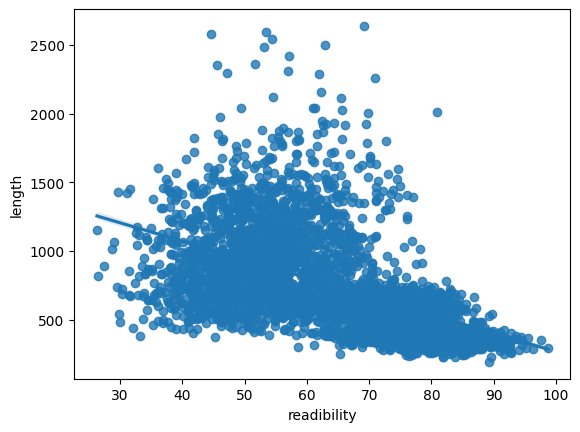

In [ ]:
sns.regplot(data=articles_df, x='readibility', y='length')

### Readibility vs. average sentence length
Similarly, longer sentences also tend to be less readible than shorter ones because they can be hard to parse for a reader.

<Axes: xlabel='readibility', ylabel='sent_length'>

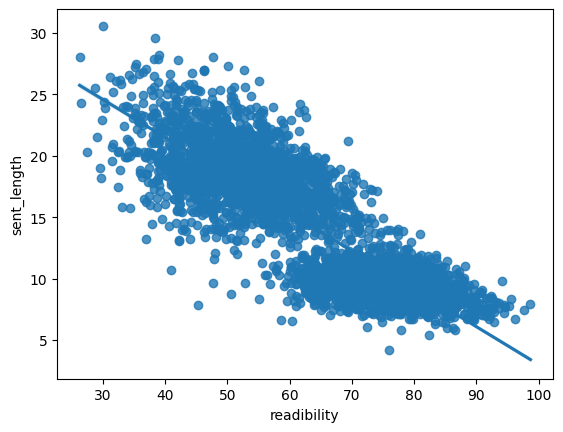

In [ ]:
sns.regplot(data=articles_df, x='readibility', y='sent_length')

### Comparing word frequencies in simple documents vs complex documents

Let's look at which words are most overrepresented in each class of document. First we'll count the frequencies of all words and calculate their unigram probabilities per class. Then we'll filter them to keep only words which exist in the English language. Finally, for words that appear in both classes, we'll divide their frequencies to find the most over-represented words in each class.

In [ ]:
complex_articles = ' '.join(articles_df[articles_df.filename.str.contains('.en.0.txt')].text.to_list())
simple_articles = ' '.join(articles_df[articles_df.filename.str.contains('.en.4.txt')].text.to_list())

complex_articles =  complex_articles.translate(str.maketrans('', '', string.punctuation)).lower()
simple_articles =  simple_articles.translate(str.maketrans('', '', string.punctuation)).lower()

complex_words = Counter(complex_articles.split())
simple_words = Counter(simple_articles.split())

sw = set(stopwords.words('english'))

# filter the words and only keep the words exist in English language
complex_words = {w:f for w, f in complex_words.items() if wn.synsets(w) and w not in sw}
simple_words = {w:f for w, f in simple_words.items() if wn.synsets(w) and w not in sw}

total_complex = sum(complex_words.values())
total_simple = sum(simple_words.values())

for word in complex_words:
  complex_words[word] /= total_complex
for word in simple_words:
  simple_words[word] /= total_simple

odds_ratio = {}

for word in complex_words:
  if word in simple_words:
    odds_ratio[word] = complex_words[word] / simple_words[word]


In [ ]:
Counter(complex_articles.split())

Counter({'ongoing': 64,
         'excavation': 29,
         'of': 50034,
         'a': 47247,
         'collapsed': 53,
         'rock': 228,
         'shelter': 89,
         'that': 22132,
         'was': 10578,
         'used': 1117,
         'by': 7611,
         'neanderthals': 33,
         'suggests': 135,
         'our': 1928,
         'extinct': 56,
         'human': 642,
         'relatives': 120,
         'organized': 88,
         'their': 6684,
         'living': 427,
         'spaces': 60,
         'according': 1336,
         'to': 51667,
         'tasks': 40,
         'researchers': 821,
         'say': 1715,
         'in': 40199,
         'paper': 282,
         'published': 347,
         'recently': 552,
         'the': 109865,
         'canadian': 77,
         'journal': 225,
         'archaeology': 37,
         'examined': 49,
         'artifacts': 80,
         'recovered': 53,
         'at': 10535,
         'riparo': 1,
         'bombrini': 1,
         'northwest': 94,
 

In [ ]:
odds_ratio = sorted(odds_ratio.items(), key=lambda x: x[1], reverse=True)

Top words in complex documents:

In [ ]:
odds_ratio[:10]

[('advocates', 110.62851736456616),
 ('status', 93.21476926088447),
 ('additional', 92.19043113713848),
 ('colleagues', 79.89837365218668),
 ('facilities', 73.75234490971079),
 ('potential', 57.53365795039938),
 ('investment', 57.36293492977505),
 ('cited', 54.289920558537105),
 ('legacy', 53.26558243479112),
 ('acknowledged', 49.16822993980718)]

Top words in simple documents:

In [ ]:
odds_ratio[-10:]

[('unfairly', 0.09455428834578304),
 ('dishonest', 0.08536151031216527),
 ('pretended', 0.08536151031216527),
 ('cleans', 0.08536151031216527),
 ('grownups', 0.08536151031216524),
 ('shiites', 0.07879524028815255),
 ('cheated', 0.07879524028815255),
 ('primaries', 0.036583504419499396),
 ('gasses', 0.036583504419499396),
 ('disagrees', 0.021340377578041317)]

Notice how the words most commonly found in complex documents are, naturally, more complex and formal than the words found in the simple documents. This minor differences add up at the document level to increase an article's complexity.

## Select a subset of the data for fine-tuning

**Problem 5.1**

Keep only English articles for which we have the 5 levels of complexity [0-4], from the most complex (version number 0) to the least complex (version number 4). Then select the 10 slugs which have the shortest original/complex documents (version 0) and keep all versions [0-4] of their documents. Your solution should have 50 total rows in this dataframe (10 slugs x 5 levels per article), with the same 6 columns as the original article metadata file.

In [ ]:
!ls ./newsela_share_2020/documents/articles_metadata.csv

ls: cannot access './newsela_share_2020/documents/articles_metadata.csv': No such file or directory


In [ ]:
random_state = 42
num_sample = 100

In [ ]:
import pandas as pd
article_df = pd.read_csv('newsela_share_2020/documents/articles_metadata.csv', sep=",", encoding="utf-8")
en_article_df = article_df[article_df['language'] == 'en']
en_group_by_artical_df = en_article_df.groupby('slug').count()
en_group_by_artical_df.index

Index(['10dollarbill-woman', '17century-selfies', '20dollarbill-female',
       '3D-limbs', '3d-indoormap', '401k-literacy', 'ADHD-game',
       'AsianAmericans-south', 'Australia-troubledkids', 'Braille-startup',
       ...
       'yurok-drugcourt', 'zebra-migration', 'zika-virus', 'zimmerman-holder',
       'zimmerman-verdict', 'zipline-injuries', 'zircon-discovery',
       'zoo-conservation', 'zuckerberg-donation', 'zuckerberg-internet'],
      dtype='object', name='slug', length=1911)

In [ ]:
def get_length(file_name):
  with open(file_name) as f:
    return len(f.read().strip().split())

In [ ]:
file_length = {}
for file_name in  en_group_by_artical_df.index:
  file_path = f"./newsela_share_2020/documents/articles/{file_name}.en.0.txt"
  file_length[file_name] = get_length(file_path)
keys = np.array(list(file_length.keys()))
values = np.array(list(file_length.values()))
least_indices = np.argsort(values)[:10]
least_10 = {keys[i]: values[i] for i in least_indices}
list(least_10.keys())
least_10_articles = [str(key) for key in list(least_10.keys())]
least_10_articles

['neanderthal-organization',
 'yosemite-fox',
 'diverse-barbie',
 'obama-wifi',
 'school-garden',
 'egypt-antiquities',
 'earth-earliestlife',
 'food-snobs',
 'income-sports',
 'music-prodigy']

In [ ]:
# TODO

article_list_filtered = en_article_df[en_article_df['slug'].isin(least_10_articles)]

##################################################

##################################################

document_df_sample = article_list_filtered


In [ ]:
grader.grade(test_case_id = 'test_documents_sample', answer = (document_df_sample.iloc[0]['slug'], document_df_sample.iloc[-1]['filename']))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Format data for fine-tuning

Below, we'll format data to fine-tune GPT. Instead of just providing the complex document as the prompt and the simple document as the completion text, we'll add an instruction within the prompt to tell GPT to simplify the document to the particular grade level of the completion text as follows:

```

{"messages": [{"role": "user", "content": "Simplify this document for a student of grade 6: <grade 12 text>"}, {"role": "assistant", "content": "<grade 6 text>"}]}
{"messages": [{"role": "user", "content": "Simplify this document for a student of grade 3: <grade 12 text>"}, {"role": "assistant", "content": "<grade 3 text>"}]}
{"messages": [{"role": "user", "content": "Simplify this document for a student of grade 5: <grade 12 text>"}, {"role": "assistant", "content": "<grade 5 text>"}]}
...
```

Where our complex sentences form the `<grade 12 text>` and the simplified sentences are the `<grade 4/5/6/8 text>`.

Make sure you fine-tuning dataset follows the above format exactly, the autograder expects the `Simplify this document for a student of grade ` part.

Also, as before, we do NOT use `system` messages here.

**Problem 5.2**

Use the dataframe you created above to create a fine-tuning dataset and write a JSON file in the above format with the name defined below. Note that since all prompts will be grade 12 documents and all completions will be grade 4/5/6/8 documents, this file will contain 40 documents in total. Use a mapping of version to grade:

```
{
    grade 8: version 1
    grade 6: version 2
    grade 5: version 3
    grade 4: version 4
}
```

Remember to remove any leading or trailing spaces in the documents.

In [ ]:
tmp_df = article_list_filtered[article_list_filtered['slug'] == "music-prodigy"]
tmp_df

,slug,language,title,grade_level,version,filename
6428,music-prodigy,en,Winging it: Piano prodigy will rack up flight ...,12.0,0,music-prodigy.en.0.txt
6429,music-prodigy,en,Abu Dhabi do: Piano prodigy turns 20 on flight...,8.0,1,music-prodigy.en.1.txt
6430,music-prodigy,en,He's not a teen anymore: Piano star turns 20 w...,6.0,2,music-prodigy.en.2.txt
6431,music-prodigy,en,Piano star turns 20 on jet to Abu Dhabi,4.0,3,music-prodigy.en.3.txt
6432,music-prodigy,en,Birthday boy: Piano star turns 20 on a plane,2.0,4,music-prodigy.en.4.txt


In [ ]:
int(tmp_df[tmp_df["version"] == 1]['grade_level'].iloc[0])

8

In [ ]:
fine_tuning_documents_filename = 'newsela_documents_finetuning_data.jsonl'

In [ ]:
# TODO
json_data = []

##################################################
for file_name in least_10_articles:
  files = article_list_filtered[article_list_filtered['slug'] == file_name]
  version_0_file_name = files[files['version'] == 0]['filename'].iloc[0]
  version_0_grade_level = int(files[files['version'] == 0]['grade_level'].iloc[0])
  file_path = f"./newsela_share_2020/documents/articles/{version_0_file_name}"
  with open(file_path) as f:
    version_0_text = f.read().strip()

  for i in range(1, 5):
    file_name = files[files["version"] == 1]['filename'].iloc[0]
    grade_level = int(files[files["version"] == 1]['grade_level'].iloc[0])
    version = int(files[files["version"] == 1]['version'].iloc[0])
    file_path = f"./newsela_share_2020/documents/articles/{file_name}"
    with open(file_path) as f:
      text = f.read().strip()
      content = f"Simplify this document for a student of grade {version_0_grade_level}: {version_0_text}"
      data = {
        "messages": [
          {"role": "user", "content": content},
          {"role": "assistant", "content": text}
        ]
      }
      json_data.append(json.dumps(data))

with open(fine_tuning_documents_filename, 'w', encoding="utf-8") as f:
  f.write('\n'.join(json_data))

##################################################


In [ ]:
with open(fine_tuning_documents_filename) as f:
  documents_json = f.read().strip().split('\n')

In [ ]:
grader.grade(test_case_id = 'test_documents_json', answer = (documents_json[0], documents_json[-1]))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [ ]:
!head '{fine_tuning_documents_filename}'

{"messages": [{"role": "user", "content": "Simplify this document for a student of grade 12: Ongoing excavation of a collapsed rock shelter that was used by Neanderthals suggests that our extinct human relatives organized their living spaces according to tasks, researchers say.\n\nIn a paper published recently in the Canadian Journal of Archaeology, researchers examined artifacts recovered at Riparo Bombrini, in northwest Italy, and concluded that their dwelling was organized around such activities as butchering animals, shaping tools and building fires.\n\n\"There has been this idea that Neanderthals did not have an organized use of space, something that has always been attributed to humans,\" said lead study author Julien Riel-Salvatore, an assistant professor of anthropology at the University of Colorado-Denver.\n\n\"We found that Neanderthals did not just throw their stuff everywhere but in fact were organized and purposeful when it came to domestic space,\" Riel-Salvatore said in 

In [ ]:
!wc '{fine_tuning_documents_filename}'

    39  34256 219291 newsela_documents_finetuning_data.jsonl


## Run the fine-tuning API

**Problem 5.3**

Run the fine-tuning API to create your fine-tuned model. You can read the documentation [here](https://platform.openai.com/docs/guides/fine-tuning/create-a-fine-tuned-model).

You may validate your training file, if you would like, using the script in this [link](https://cookbook.openai.com/examples/chat_finetuning_data_prep).

Although, this is NOT required.

Once you have the data validated, the file needs to be uploaded using the Files API in order to be used with a fine-tuning jobs:

In [ ]:
##################################################

fine_tuning_file = client.files.create(
  file=open(fine_tuning_documents_filename, "rb"),
  purpose='fine-tune'
)
##################################################
fine_tuning_file_id = fine_tuning_file.id
fine_tuning_file_id # thei id is: file-V65abVc4Cq5qtCXTk555L8

'file-EXU2ZEKSW2pqTi8rpQ18do'

After ensuring you have uploaded the file, the next step is to create a fine-tuning job.

In [ ]:
##################################################

fine_tuning_job = client.fine_tuning.jobs.create(
  training_file=fine_tuning_file_id,
  model="gpt-4o-mini-2024-07-18",
  suffix="university-of-pennsylvania:"
)
##################################################
##################################################
fine_tuning_job_id = fine_tuning_job.id

fine_tuning_job_id # the tuning job id is: ftjob-ymcdmgrItUPzSHKmwcmfU3WT

'ftjob-ymcdmgrItUPzSHKmwcmfU3WT'

In [ ]:
fine_tuning_job_id = "ftjob-ymcdmgrItUPzSHKmwcmfU3WT"

You may monitor the status of your fine-tuning job using the below code:

In [ ]:
response = client.fine_tuning.jobs.list_events(fine_tuning_job_id)

events = response.data
events.reverse()

for event in events:
    print(event.message)


Step 108/120: training loss=0.00
Step 109/120: training loss=0.00
Step 110/120: training loss=0.00
Step 111/120: training loss=0.00
Step 112/120: training loss=0.01
Step 113/120: training loss=0.00
Step 114/120: training loss=0.00
Step 115/120: training loss=0.00
Step 116/120: training loss=0.00
Step 117/120: training loss=0.00
Step 118/120: training loss=0.00
Step 119/120: training loss=0.01
Step 120/120: training loss=0.00
Checkpoint created at step 40
Checkpoint created at step 80
New fine-tuned model created
Evaluating model against our usage policies
Moderation checks for snapshot ft:gpt-4o-mini-2024-07-18:personal:university-of-pennsylvania:By4Wv6UM passed.
Usage policy evaluations completed, model is now enabled for sampling
The job has successfully completed


Once your fine-tune is completed, you should see a message in the output of the above code saying   
`The job has successfully completed`.

In [ ]:
# you may also check the status of your fine-tuning job in the UI using this link
print(f"https://platform.openai.com/finetune/{fine_tuning_job_id}")

https://platform.openai.com/finetune/ftjob-ymcdmgrItUPzSHKmwcmfU3WT


You can retrieve your model ID, by running this command

In [ ]:
# prints your fine-tuned model ID
client.fine_tuning.jobs.retrieve(fine_tuning_job_id).fine_tuned_model

'ft:gpt-4o-mini-2024-07-18:personal:university-of-pennsylvania:By4Wv6UM'

The above output will contain the ID of your model, which you should should copy down for use later. It will look something like this:

```
ft:gpt-4o-mini-2024-07-18:university-of-pennsylvania::BBYu06Qj
```

If you forget to write it down, you can list your fine-tuned runs and models with the following command:

In [ ]:
client.fine_tuning.jobs.list(limit=10)

In [ ]:
fine_tuned_model_doc = 'ft:gpt-4o-mini-2024-07-18:personal:university-of-pennsylvania:By4Wv6UM' # replace with your REAL ft-model ID from above

In [ ]:
grader.grade(test_case_id = 'test_finetune_doc_created', answer = (openai_api_key, fine_tuned_model_doc))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Test your fine-tuned model

**Problem 5.4**

Use your fine-tuned model to generate simplified sentences.

In [ ]:
# TODO

def generate_simple_documents(complex_document, instruction_prompt, finetuned_model):

  response = None
  content = f"{instruction_prompt}: {complex_document}"
  messages = [
        {"role": "user", "content": content},
  ]

  response = client.chat.completions.create(
      model=finetuned_model,
      messages=messages,
      temperature=0.7,
      max_tokens=256,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0,
      stop=["\n"]
  )
  time.sleep(1)

  return response.choices[0].message.content.strip()

finetuned_model_doc = "ft:gpt-4o-mini-2024-07-18:personal:university-of-pennsylvania:By4Wv6UM" # replace with your REAL ft-model ID from above
instruction_prompt = 'Simplify this document for a student of grade 1:'

fine_tune_test_doc = generate_simple_documents(original_sentence, instruction_prompt, finetuned_model_doc)
fine_tune_test_doc

'Today, jobs change quickly. Because of this, it is very important to have people with different skills in the workplace.'

In [ ]:
grader.grade(test_case_id = 'test_finetune_doc_eval', answer = (openai_api_key, fine_tune_test_doc, original_sentence))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now that we have finetuned a new model to simplify documents, we can test it out in the same manner as before.

# Section 6: Evaluation

In this section, you will attempt to evaluate how well each of the models you built (zeroshot, fewshot, finetuning) perform at this task. You will do a series of evaluations for 10 random sentences where you will be presented with two completions for a sentence and asked to pick which is better. Your responses will decide which model wins the most out of all three. Finally, you will write your thoughts about what you learned from this exercise at the end.

In [56]:
prompt
input_sentences['completion_2'] = input_sentences['prompt'].apply(lambda x: simplify_fewshot(fewshot_prompt, x))

In [37]:
input_sentences = pd.DataFrame(sentences_df.sample(10, random_state=random_state).prompt).reset_index().drop(columns=['index'])

In [40]:
# TODO

##################################################

zeroshot_prompt = "Please simplify a sentence by using a simpler word in the sentence. The sentence need to be simplified is: "
fewshot_prompt = prompt
fine_tuned_model = "ft:gpt-4o-mini-2024-07-18:personal:university-of-pennsylvania:By491rh0" # use your model ID from section 4

##################################################

input_sentences['completion_1'] = input_sentences['prompt'].apply(lambda x: simplify_zeroshot(zeroshot_prompt, x))
input_sentences['completion_2'] = input_sentences['prompt'].apply(lambda x: simplify_fewshot(fewshot_prompt, x))
input_sentences['completion_3'] = input_sentences['prompt'].apply(lambda x: generate_simple_sentence(x, fine_tuned_model))


In [42]:
type(input_sentences)

pandas.core.frame.DataFrame

In [57]:
input_sentences.to_csv("input_sentences.csv", index=False)

In [58]:
!cp ./input_sentences.csv /content/drive/MyDrive/CIS5300/HW9/

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
ratings = {1:0, 2:0, 3:0}
annot = []

for index, row in input_sentences.iterrows():
  s1, s2 = 1, 2
  for i in range(1,4):
    if i == 2:
      s1, s2 = 2, 3
    elif i == 3:
      s1, s2 = 1, 3

    print('-'*50)
    print(f'\nTask {index*3+i} of 30')
    print('Original sentence:\t', row['prompt'])
    print('Simplification 1:\t', row['completion_'+str(s1)])
    print('Simplification 2:\t', row['completion_'+str(s2)])
    r = int(input('Which simplification is better? Enter 1 or 2: '))
    if i == 1:
      ratings[r]+=1
    if i == 2:
      ratings[r+1]+=1
    elif i == 3:
      if r == 1:
        ratings[1]+=1
      else:
        ratings[3]+=1
    annot.append((row['prompt'], row['completion_'+str(s1)], row['completion_'+str(s2)], r))

annot_df = pd.DataFrame(annot, columns=['input', 'simplification_1', 'simplification_2', 'choice'])
annot_df.to_csv('human_eval.csv', sep='\t')

--------------------------------------------------

Task 1 of 30
Original sentence:	 It needs the aid to help it fight Russia from taking more of its land.
Simplification 1:	 It needs help to stop Russia from taking more of its land.
Simplification 2:	 It seems you're referencing two separate topics: President Obama's speech to tribal leaders about his commitment to Indian Country and a situation regarding aid to a country dealing with Russian aggression.
Which simplification is better? Enter 1 or 2: 1
--------------------------------------------------

Task 2 of 30
Original sentence:	 It needs the aid to help it fight Russia from taking more of its land.
Simplification 1:	 It seems you're referencing two separate topics: President Obama's speech to tribal leaders about his commitment to Indian Country and a situation regarding aid to a country dealing with Russian aggression.
Simplification 2:	 It needs the aid to help it fight Russia from taking more of its land.
Which simplification

In [63]:
!cp ./human_eval.csv /content/drive/MyDrive/CIS5300/HW9/

In [62]:
!cp ./human_eval.csv /


./human_eval.csv


In [60]:
eval_score = pd.DataFrame(ratings.items(), columns=['Model', 'Score'])
eval_score['Model'] = eval_score['Model'].replace([1, 2, 3], ['Zero-shot', 'Few-shot', 'Fine-tuning'])

<Axes: xlabel='Model', ylabel='Score'>

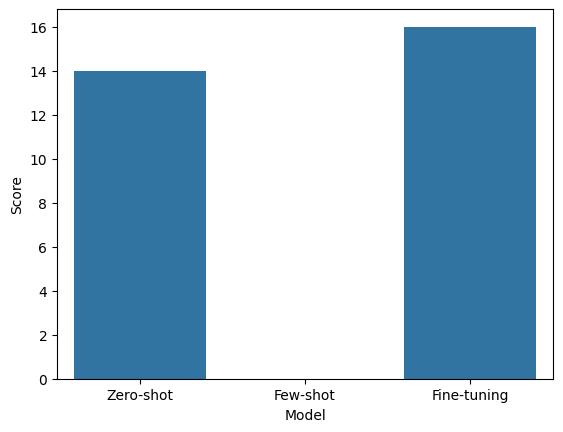

In [61]:
sns.barplot(data=eval_score, x='Model', y='Score')

**Problem 6.1** What did you learn from the above exercise? Comment on the overall performance of the three systems and compare the quality of their outputs against each other. Were the results expected or unexpected? And why? Write your thoughts below. Your answers should be included in your separate **"writeup.pdf"** file and will be manually graded (5 points).

Do not be worried if your fine-tuned model performs worse than your zero-shot or few-shot; fine-tuning does not always lead to better performance. For a funny example of where fine-tuning did not work as expected, see [this](https://rosslazer.com/posts/fine-tuning/).

In [ ]:
# TODO in writeup.pdf file

##################################################
"""
The zero-shot actually has the best performance. The 2nd is Fine-tuning.
The few-shot model has the worst performance.
"""

##################################################


# Final Thoughts

Text simplification is an fascinating application of natural language processing and can teach us much about transforming sequences of text into new sequences of text which exhibit some desired property, whether it be a different language or style of writing.

In this homework, we thought about how we would approach this task as humans, how we can measure simplicitly programmatically, and we even tried to think of and implement some logic to simplify a sentence. We then explored how we can use large language models to perform this task, both by instructing them explicitly, simply just giving them examples of what we expect, and putting both approaches together. Finally, we evaluated how well each of these approaches did in order to gain insight into the best way to solve this problem.

We hope you had fun doing this homework, and we encourage you to use the techniques you learned here at other tasks you find interesting.

# Submission
Here are the deliverables you need to submit to GradeScope:
- Code:
    - This notebook and py file: rename to `homework9.ipynb` and `homework9.py`. You can download the notebook and py file by going to the top-left corner of this webpage, `File -> Download -> Download .ipynb/.py`
- PDF:
  - Your `writeup.pdf` with answers to problems 1.2 and 6.1
- Annotations:
    - The `annotations.csv` file from your human evaluation exercise.